<a href="https://colab.research.google.com/github/byunsy/brain-mri-segmentation/blob/main/Brain_MRI_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain MRI Segmentation


## 01. Import Necessary Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

In [2]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

In [3]:
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

## 02. Attain Dataset from Kaggle

In [4]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

100% 711M/714M [01:03<00:00, 19.9MB/s]
100% 714M/714M [01:03<00:00, 11.8MB/s]


In [9]:
!unzip /content/lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

## 03. Understanding the Dataset

In [10]:
base_dir = "/content/kaggle_3m"

In [11]:
!rm -r /content/lgg-mri-segmentation

In [12]:
data_map = []

for sub_dir_path in glob.glob(os.path.join(base_dir, "*")):

    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])

    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/kaggle_3m/data.csv'
[Errno 20] Not a directory: '/content/kaggle_3m/README.md'


In [13]:
data_map[:20]

['TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_22_mask.tif',
 'TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_3_mask.tif',
 'TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_21.tif',
 'TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_19.tif',
 'TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif',
 'TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif',
 'TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif',
 'TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_19_mask.tif',
 'TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif',
 'TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS

In [14]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df

,patient_id,path
0,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
1,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
2,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
3,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
4,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
...,...,...
7853,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_DU_7309_19960831/TCGA_...
7854,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_DU_7309_19960831/TCGA_...
7855,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_DU_7309_19960831/TCGA_...
7856,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_DU_7309_19960831/TCGA_...


In [15]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

In [16]:
print(len(df_imgs))
print(len(df_masks))

3929
3929


In [17]:
data_map[:5]

['TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_22_mask.tif',
 'TCGA_CS_4941_19960909',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_3_mask.tif',
 'TCGA_CS_4941_19960909']

In [18]:
len("/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_")

63

In [19]:
# File path line length images for later sorting
BASE_LEN = 63 
END_IMG_LEN = 4 
END_MASK_LEN = 9

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [20]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks})

# Determines whether the mask has pixels in them
# - some will be blank black images
# - while some will have white pixels
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    

brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,0
1,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_DU_8162_19961029/TCGA_...,/content/kaggle_3m/TCGA_DU_8162_19961029/TCGA_...,0
2,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_FG_8189_20030516/TCGA_...,/content/kaggle_3m/TCGA_FG_8189_20030516/TCGA_...,0
3,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...,0
4,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_CS_6188_20010812/TCGA_...,/content/kaggle_3m/TCGA_CS_6188_20010812/TCGA_...,0
...,...,...,...,...
3924,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3925,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3926,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3927,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0


## 04. Data Exploration and Visualization

In [21]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [22]:
num_absent, num_present = brain_df['mask'].value_counts()

print("Number of masks with no white pixels  :", num_absent)
print("Number of masks with some white pixels:", num_present)

Number of masks with no white pixels  : 2556
Number of masks with some white pixels: 1373


In [23]:
total_num_samples = num_absent + num_present
num_classes = 2

weight_absent  = total_num_samples / (num_classes * num_absent)
weight_present = total_num_samples / (num_classes * num_present)

print('Weight for ABSENT   (class 0): {:.2f}'.format(weight_absent))
print('Weight for PRESENT  (class 1): {:.2f}'.format(weight_present))

Weight for ABSENT   (class 0): 0.77
Weight for PRESENT  (class 1): 1.43


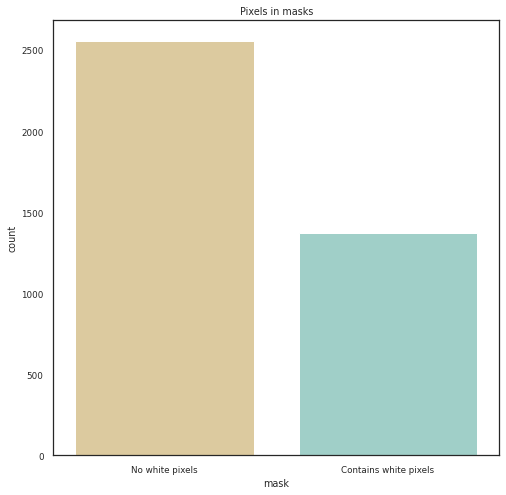

In [24]:
sns.set(rc={ 'figure.figsize':(8.0, 8.0) }, style='white', font_scale=0.8)
sns.countplot(x='mask', data=brain_df, palette='BrBG')

plt.title('Pixels in masks')
plt.xticks(ticks=[0, 1], labels=['No white pixels', 'Contains white pixels'])

plt.show()

Text(0.5, 1.0, 'MRI Scan')

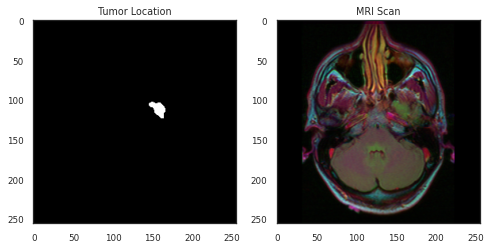

In [25]:
# Traverse and select the first mri scan that has a valid mask 
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

# Display 
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));
plt.title('MRI Scan')

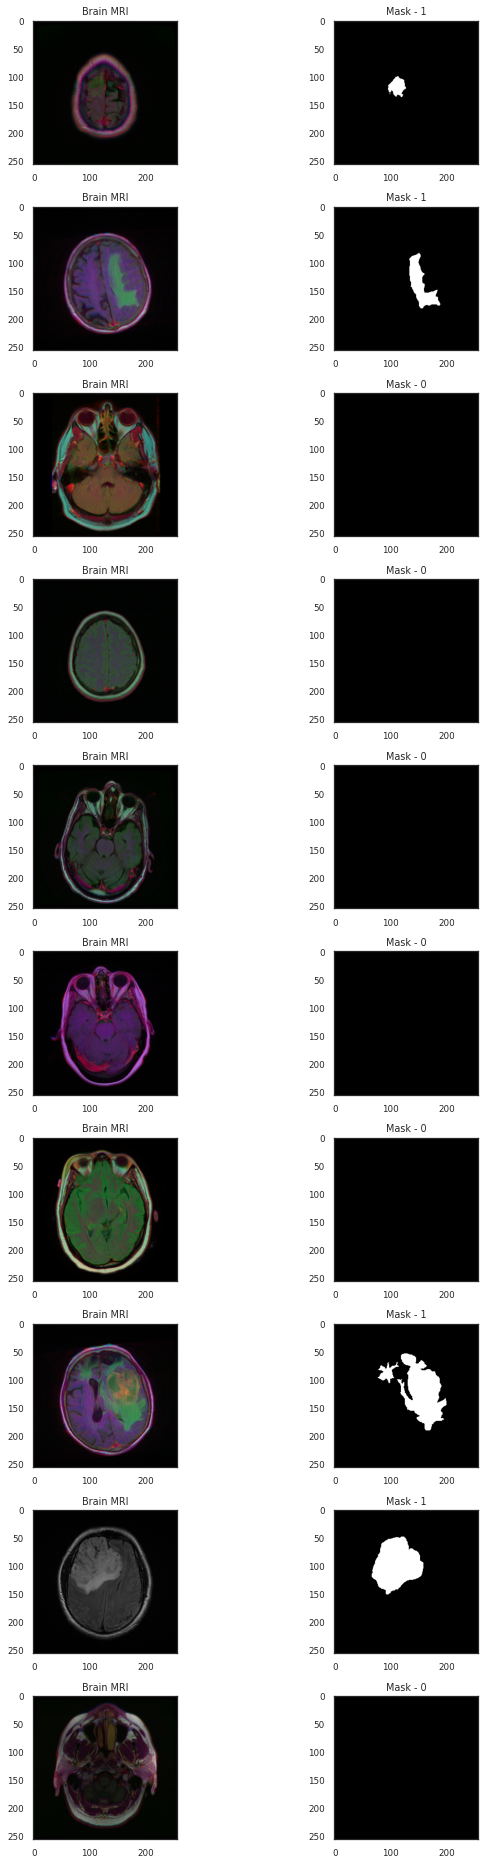

In [26]:
# Visualization of Brain MRI scans and Mask images
# - randomly select 10 pairs of mri-scan and masks

# Create 10x2 plot figure (10 rows x 2 cols)
fig, axs = plt.subplots(10,2, figsize=(10,26))

for x in range(10):
  i = random.randint(0, len(brain_df)) # select a random index

  axs[x][0].title.set_text("Brain MRI") # MRI title
  axs[x][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 

  axs[x][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # Mask title (0 or 1)
  axs[x][1].imshow(cv2.imread(brain_df.mask_path[i])) # show corresponding mask

fig.tight_layout()

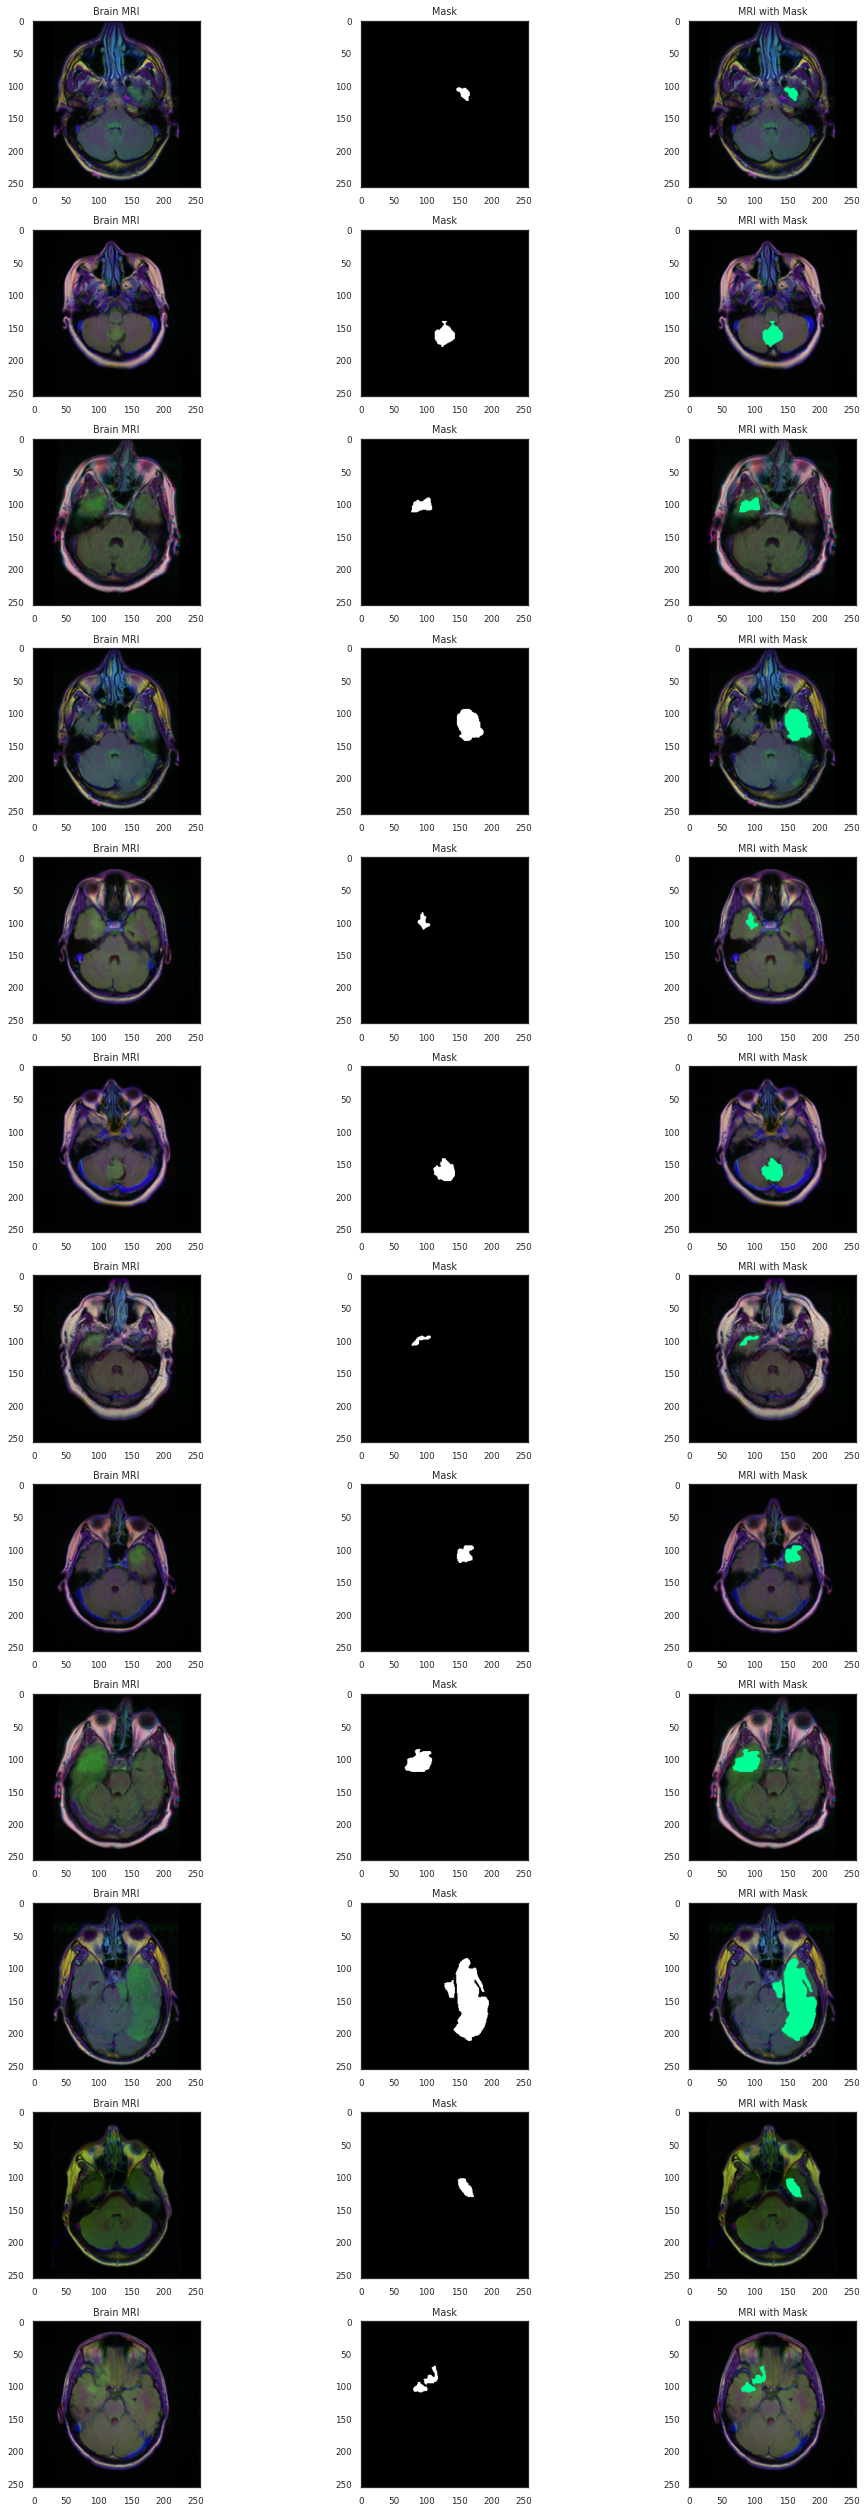

In [27]:
fig,axs = plt.subplots(12,3, figsize=(15,35))

count = 0
for i, mask in enumerate(brain_df['mask']):
    if (mask==1):
        
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        
        count +=1

    if (count==12):
        break
        
fig.tight_layout()

## 05. Data Preparation

In [28]:
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,0
1,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_DU_8162_19961029/TCGA_...,/content/kaggle_3m/TCGA_DU_8162_19961029/TCGA_...,0
2,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_FG_8189_20030516/TCGA_...,/content/kaggle_3m/TCGA_FG_8189_20030516/TCGA_...,0
3,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...,0
4,TCGA_CS_4941_19960909,/content/kaggle_3m/TCGA_CS_6188_20010812/TCGA_...,/content/kaggle_3m/TCGA_CS_6188_20010812/TCGA_...,0
...,...,...,...,...
3924,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3925,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3926,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3927,TCGA_DU_7309_19960831,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0


In [29]:
brain_df_src = brain_df.drop(columns=['patient_id'])
brain_df_src

,image_path,mask_path,mask
0,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,0
1,/content/kaggle_3m/TCGA_DU_8162_19961029/TCGA_...,/content/kaggle_3m/TCGA_DU_8162_19961029/TCGA_...,0
2,/content/kaggle_3m/TCGA_FG_8189_20030516/TCGA_...,/content/kaggle_3m/TCGA_FG_8189_20030516/TCGA_...,0
3,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...,/content/kaggle_3m/TCGA_DU_7306_19930512/TCGA_...,0
4,/content/kaggle_3m/TCGA_CS_6188_20010812/TCGA_...,/content/kaggle_3m/TCGA_CS_6188_20010812/TCGA_...,0
...,...,...,...
3924,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3925,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0
3926,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3927,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_...,0


In [30]:
brain_df_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


In [31]:
brain_df_src['mask'] = brain_df_src['mask'].astype('string')
brain_df_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   string
dtypes: object(2), string(1)
memory usage: 92.2+ KB


In [32]:
BATCH_SIZE = 16
IMG_SHAPE = 256

In [33]:
class_weight = {0: weight_absent, 1: weight_present}

In [34]:
# This function will plot images in the form of a grid with 1 row and 5 columns 
# where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Split into train, test, and validation sets

In [35]:
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

# First split into train and test sets at 80:20 ratio
# Second split into train validation at 75:25 ratio
# - results in 60:20:20 ratio (train, val, test)
train, test = train_test_split(brain_df_src, test_size=0.2, random_state=1)
train, val = train_test_split(train, test_size=0.25, random_state=1)

### Data Generation and Augmentation

Found 2357 validated image filenames belonging to 2 classes.


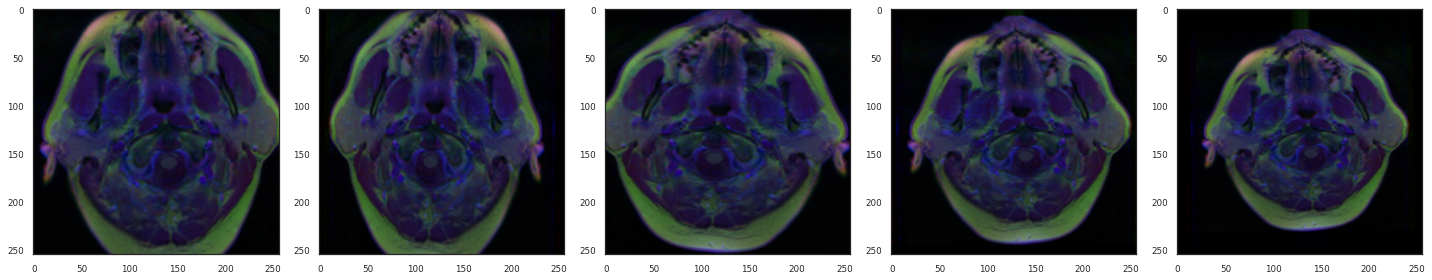

In [36]:
# TRAIN
image_gen_train = ImageDataGenerator(rescale=1./255., 
                                     horizontal_flip=True, 
                                     zoom_range=0.20)

train_data_gen = image_gen_train.flow_from_dataframe(
    train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE)
)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [37]:
# VALID
image_gen_val = ImageDataGenerator(rescale=1./255.)
val_data_gen = image_gen_val.flow_from_dataframe(
    val,
    directory='./',
    x_col='image_path',
    y_col='mask',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE)
)

Found 786 validated image filenames belonging to 2 classes.


In [38]:
# TEST
image_gen_test = ImageDataGenerator(rescale=1./255.)
test_data_gen = image_gen_test.flow_from_dataframe(
    test,
    directory='./',
    x_col='image_path',
    y_col='mask',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=(IMG_SHAPE,IMG_SHAPE)
)

Found 786 validated image filenames belonging to 2 classes.


## 06. Create CNN Model

In [39]:
model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),

    tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 512)       147968    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        147488    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

## Compile the Model

In [41]:
# Create optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# lss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
lss = 'categorical_crossentropy'

# Compile the model
model.compile(optimizer=opt,
              loss=lss,
              metrics=['accuracy'])

In [42]:
# Earlystopping will stop the learning process when there are no
# ten consecutive improvements in the val_loss.
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min',
                              verbose=1,
                              patience=15)

# Create a checkpoint based on val_loss
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="my_checkpoint.h5",
                                                verbose=1, 
                                                save_best_only=True)

In [44]:
history = model.fit(train_data_gen, 
                    epochs=50, 
                    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
                    validation_data=val_data_gen,
                    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE))),
                    class_weight=class_weight, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
148/148 [==============================] - 48s 277ms/step - loss: 2.0341 - accuracy: 0.4753 - val_loss: 1.1491 - val_accuracy: 0.4427

Epoch 00001: val_loss improved from inf to 1.14906, saving model to my_checkpoint.h5
Epoch 2/50
148/148 [==============================] - 40s 273ms/step - loss: 0.9827 - accuracy: 0.4288 - val_loss: 0.6738 - val_accuracy: 0.6603

Epoch 00002: val_loss improved from 1.14906 to 0.67379, saving model to my_checkpoint.h5
Epoch 3/50
148/148 [==============================] - 40s 272ms/step - loss: 0.6688 - accuracy: 0.6073 - val_loss: 0.6272 - val_accuracy: 0.6005

Epoch 00003: val_loss improved from 0.67379 to 0.62721, saving model to my_checkpoint.h5
Epoch 4/50
148/148 [==============================] - 40s 271ms/step - loss: 0.6360 - accuracy: 0.6122 - val_loss: 0.5702 - val_accuracy: 0.6756

Epoch 00004: val_loss improved from 0.62721 to 0.57019, saving model to my_checkpoint.h5
Epoch 5/50
148/148 [==============================] - 40s 269ms/

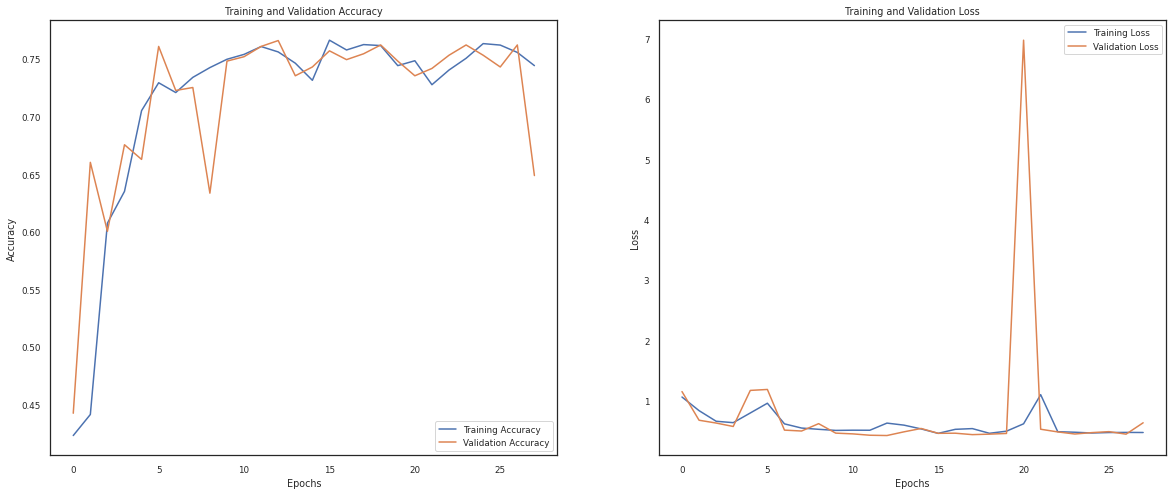

In [46]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# x-axis
epochs_range = range(28)

# First figure: Model Accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Second figure: Model Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()